In [1]:
import tensorflow as tf
import csv
import os
import pandas as pd
import numpy as np
import shutil
import PIL
from pathlib import Path
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import glob
import piexif
from collections import Counter
from matplotlib import pyplot as plt
from PIL import Image
from PIL import ImageFile
Image.MAX_IMAGE_PIXELS = None
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau 
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from itertools import tee 
from sklearn import metrics
from tensorflow.keras import backend as K
from sklearn.metrics import f1_score,precision_score,recall_score
import seaborn as sns

In [2]:
labelsCsv = pd.read_csv("C:/Users/manta/Desktop/new.csv")

# When generating datasets from dataframe,using ImageDataGenerator, we noticed that train and valid sets
# had a class less than the test set. So comparing the labels we realised that one single tittle had the genre
# 'Game-Show' which we have to remove so each set has the same classes
#labelsCsv = labelsCsv[~labelsCsv.genres.str.contains("Game-Show")]
#labelsCsv = labelsCsv[~labelsCsv.genres.str.contains("Short")]
#labelsCsv.to_csv("labels.csv", sep=",", index=False)

nfiles = 0

# We remove exif metadata from pictures and resize them to max size of 128x128, while maintaining the aspect ratio
# of the original photo

#for filename in glob.iglob('E:/IMDB_/*.jpg', recursive=True):
    #nfiles = nfiles + 1
    #print("About to process file %d, which is %s." % (nfiles,filename))
    #piexif.remove(filename)

size=(128, 128)

#for filename in glob.iglob('E:/IMDB_rs/*.jpg', recursive=True):
    #im = Image.open(filename)
    #im.thumbnail(size, Image.ANTIALIAS)
    #x = filename.split("\\", 1)
    #im.save("C:/IMDB_mr/"+x[1], "JPEG")



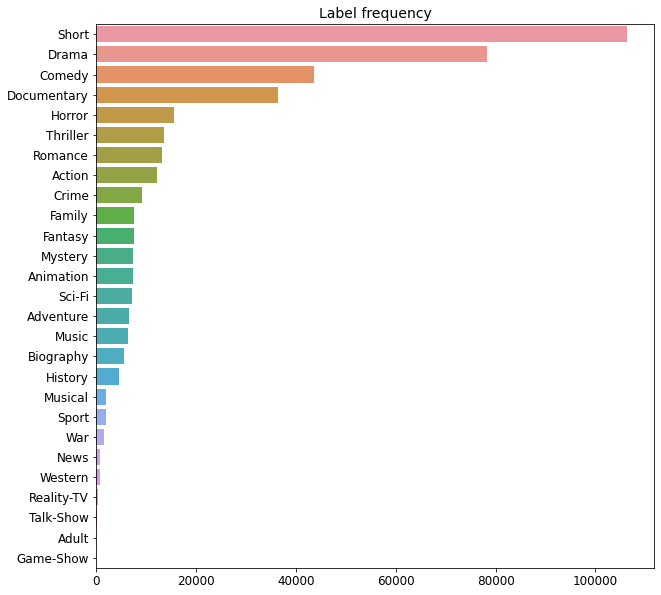

In [3]:
# Get label frequencies in descending order
label_freq = labelsCsv['genres'].apply(lambda s: str(s).split(',')).explode().value_counts().sort_values(ascending=False)

# Bar plot
plt.figure(figsize=(10,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [4]:
print(label_freq)

Short          106387
Drama           78246
Comedy          43675
Documentary     36538
Horror          15659
Thriller        13613
Romance         13234
Action          12244
Crime            9257
Family           7663
Fantasy          7646
Mystery          7431
Animation        7401
Sci-Fi           7310
Adventure        6581
Music            6331
Biography        5673
History          4589
Musical          2010
Sport            1989
War              1530
News              767
Western           723
Reality-TV        430
Talk-Show         212
Adult              53
Game-Show          22
Name: genres, dtype: int64


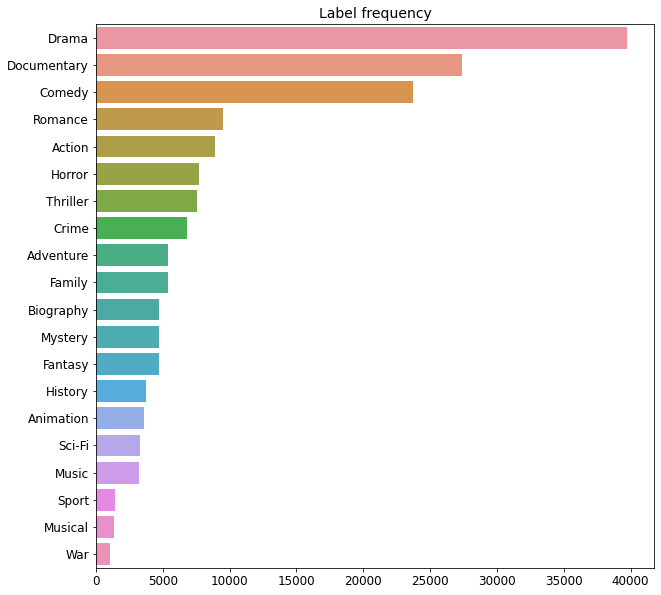

In [5]:
#we keep only the genres with more than 1000 instances 
under1000 = list(label_freq[label_freq<1000].index)
labelsCsv = labelsCsv[~labelsCsv.genres.str.contains('Short')]
for x in under1000:
    labelsCsv = labelsCsv[~labelsCsv.genres.str.contains(x)] 

label_freq_new = labelsCsv['genres'].apply(lambda s: str(s).split(',')).explode().value_counts().sort_values(ascending=False)
# Bar plot after we dropped the classes
plt.figure(figsize=(10,10))
sns.barplot(y=label_freq_new.index.values, x=label_freq_new, order=label_freq_new.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [6]:
print(label_freq_new)

Drama          39754
Documentary    27367
Comedy         23742
Romance         9518
Action          8900
Horror          7690
Thriller        7530
Crime           6792
Adventure       5375
Family          5367
Biography       4753
Mystery         4701
Fantasy         4698
History         3724
Animation       3617
Sci-Fi          3277
Music           3225
Sport           1446
Musical         1346
War             1031
Name: genres, dtype: int64


In [7]:
all_genres = [[genre for genre in cel.split(',')] for cel in labelsCsv.genres]
one_hot = MultiLabelBinarizer()
y_s =one_hot.fit_transform(np.array(all_genres))
y_s


c:\programdata\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
len(y_s[0])

20

In [9]:
# testss = pd.DataFrame(one_hot.fit_transform(all_genres),columns=one_hot.classes_, index=labelsCsv.index)
# testss

In [10]:
# creating and formating the dataset that we are going to use
d = {'filename' : [tconst + ".jpg" for tconst in labelsCsv.tconst],
    'labels' : [[genre for genre in cel.split(',')] for cel in labelsCsv.genres]}

img_metadata_df = pd.DataFrame(d)

# splitting to train and test
train, test = train_test_split(img_metadata_df, test_size=0.20, random_state=9, shuffle=True)


In [11]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [12]:
# img_iter_train.classes
# #counter = Counter(tuple(item) for item in img_iter_train.classes)
# flat_list = [item for sublist in img_iter_train.classes for item in sublist]
# counter = Counter(flat_list)
# counter = dict(sorted(counter.items()))
# counter

In [47]:
THRESHOLD = 0.5
def precision(y_true, y_pred, threshold_shift=0.5-THRESHOLD):

    # just in case 
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))

    precision = tp / (tp + fp)
    return precision


def recall(y_true, y_pred, threshold_shift=0.5-THRESHOLD):

    # just in case 
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fn = K.sum(K.round(K.clip(y_true - y_pred_bin, 0, 1)))

    recall = tp / (tp + fn)
    return recall

def fbeta(y_true, y_pred, threshold_shift=0.5-THRESHOLD):
    #balanced on precision and recall
    beta = 1

    # just in case 
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall) 


In [48]:
def create_dataset_splits(train,test,directory):

    img_gen = ImageDataGenerator(rescale=1./255., validation_split=0.20)

    img_iter_train = img_gen.flow_from_dataframe(
        dataframe=train,
        shuffle=True,
        seed = 42,
        directory=directory,
        x_col='filename',
        y_col='labels',
        class_mode='categorical',
        target_size=(128, 128),
        batch_size=100,
        subset='training'
    ) 

    img_iter_val = img_gen.flow_from_dataframe(
        dataframe=train,
        shuffle=True,
        seed=42,
        directory=directory,
        x_col='filename',
        y_col='labels',
        class_mode='categorical',
        target_size=(128, 128),
        batch_size=200,
        subset='validation'
    ) 

    test_gen=ImageDataGenerator(rescale=1./255.)

    img_iter_test=test_gen.flow_from_dataframe(
        dataframe=test,
        directory=directory,
        x_col='filename',
        y_col='labels',
        class_mode='categorical',
        batch_size=1,
        seed=42,
        shuffle=False,
        target_size=(128, 128)
    )
    
    return img_iter_train,img_iter_val,img_iter_test

In [49]:
def create_model(input_shape,output_dim):
    
    model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),        
    MaxPooling2D(pool_size=(2, 2)),    
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),        
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu'),    
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
#     Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
#     Conv2D(filters=256, kernel_size=(3,3), activation='relu'),    
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.25),        
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),    
#     Dense(512, activation='relu'),
#     Dropout(0.5),
    Dense(output_dim, activation='sigmoid')
    ])
    
    return model

In [50]:
# def create_model(input_shape):
    
#     base_mobnet = tf.keras.applications.MobileNetV2( include_top=False, weights="imagenet", input_shape=input_shape)
#     base_mobnet.layers.pop()
#     mob_model = Model(base_mobnet.input, base_mobnet.layers[-6].output)
    
#     for layer in mob_model.layers:
#         layer.trainable = False 
        
#     #Adding the final layers to the above base models where the actual classification is done in the dense layers
#     model_mobnet = Sequential()
#     model_mobnet.add(mob_model) 
#     model_mobnet.add(Flatten()) 
#     model_mobnet.add(Dense(1024,activation=('relu'),input_dim=512))
#     model_mobnet.add(Dropout(.4))
#     model_mobnet.add(Dense(512,activation=('relu'))) 
#     model_mobnet.add(Dropout(.4))
#     model_mobnet.add(Dense(256,activation=('relu'))) 
#     model_mobnet.add(Dropout(.4))
#     model_mobnet.add(Dense(128,activation=('relu')))
#     model_mobnet.add(Dropout(.4))
#     model_mobnet.add(Dense(21,activation=('sigmoid')))
    
#     return model_mobnet 

In [51]:
def train_model(model,train_dataset,valid_dataset,test_dataset,learning_rate,epochs):
    
    step_train=train_dataset.n//train_dataset.batch_size
    step_valid=valid_dataset.n//valid_dataset.batch_size
    step_test=test_dataset.n//test_dataset.batch_size
    
    
    model.compile(optimizer=Adam(lr = learning_rate), 
              loss='binary_crossentropy', 
              metrics=[precision,recall,fbeta])
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                                    verbose=2, mode='min', min_lr=learning_rate/100000)
    
    history = model.fit_generator(
        generator=train_dataset,
        validation_data=valid_dataset,
        epochs=epochs,
        steps_per_epoch=step_train,
        validation_steps=step_valid 
        )
    
    return history

In [52]:
img_iter_train,img_iter_val,img_iter_test = create_dataset_splits(train,test,"C:/IMDB_rs/")
model = create_model((128,128,3),20)
model.summary()

c:\programdata\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 64034 validated image filenames belonging to 20 classes.


c:\programdata\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 16008 validated image filenames belonging to 20 classes.
Found 20012 validated image filenames belonging to 20 classes.
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 58, 58, 64)        36928

In [53]:
history = train_model(model,img_iter_train,img_iter_val,img_iter_test,0.001,100)

Epoch 1/100
640/640 [==============================] - 99s 155ms/step - loss: 0.2522 - precision: 0.5014 - recall: 0.0122 - fbeta: 0.0201 - val_loss: 0.2473 - val_precision: 1.0000 - val_recall: 2.8850e-10 - val_fbeta: 5.7699e-10
Epoch 2/100
640/640 [==============================] - 98s 153ms/step - loss: 0.2470 - precision: 0.6202 - recall: 0.0078 - fbeta: 0.0148 - val_loss: 0.2453 - val_precision: 0.4706 - val_recall: 0.0202 - val_fbeta: 0.0386
Epoch 3/100
640/640 [==============================] - 98s 152ms/step - loss: 0.2449 - precision: 0.5472 - recall: 0.0183 - fbeta: 0.0346 - val_loss: 0.2424 - val_precision: 0.6238 - val_recall: 0.0053 - val_fbeta: 0.0105
Epoch 4/100
640/640 [==============================] - 98s 153ms/step - loss: 0.2426 - precision: 0.5384 - recall: 0.0441 - fbeta: 0.0802 - val_loss: 0.2414 - val_precision: 0.5281 - val_recall: 0.0602 - val_fbeta: 0.1078
Epoch 5/100
640/640 [==============================] - 98s 152ms/step - loss: 0.2407 - precision: 0.5422

KeyboardInterrupt: 

In [ ]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['training', 'validation'], loc='upper left')
# plt.show()

In [ ]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

In [ ]:
test_generator.reset()
model.evaluate_generator(generator = test_generator, 
                         steps=STEP_SIZE_TEST,
                         verbose=1)

In [ ]:
model.save('C:/IMDB_mr/Model/')
np.savetxt("preds.csv", pred, delimiter=",")

# TEXT ANALYSIS

In [56]:
len(labelsCsv.desc)

100056

In [57]:
len(y_s)

100056

In [118]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from tensorflow.keras.layers import Embedding
from nltk.stem.snowball import SnowballStemmer 
import re

# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [119]:
textdata = labelsCsv[['desc','genres']]
textdata= textdata.dropna()
textdata = textdata[textdata['desc'].notnull()]
txtrain, txtest = train_test_split(textdata, test_size=0.20, random_state=9, shuffle=True)

In [120]:
### Text Normalizing function. Part of the following function was taken from this link. 
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"directed", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"\=", " = ", text)
    

    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    
    return text


In [121]:
txtrain['desc'] = txtrain['desc'].map(lambda x: clean_text(x))

c:\programdata\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [145]:
### Create sequence
vocabulary_size = 120000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(txtrain['desc'] )   #sto test
sequences = tokenizer.texts_to_sequences(txtrain['desc'] )  #sto test
#vocabulary_size = len(tokenizer.word_index) + 1
maxlen = max([len(x) for x in sequences])
xtrain = pad_sequences(sequences, maxlen)  #kai sto test

print(xtrain.shape)

(79684, 76)


In [146]:
xtrain

array([[    0,     0,     0, ..., 52998, 16419, 78720],
       [    0,     0,     0, ..., 40849,  5493,  1188],
       [    0,     0,     0, ..., 33561,  1294, 33561],
       ...,
       [    0,     0,     0, ...,    10,   166,     7],
       [    0,     0,     0, ...,  2543,   639,   167],
       [    0,     0,     0, ...,   176, 18126, 17021]])

In [147]:
all_genres_tx = [[genre for genre in cel.split(',')] for cel in txtrain.genres] #sto test
ytrain = one_hot.fit_transform(np.array(all_genres_tx))   #sto test
ytrain.shape

c:\programdata\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


(79684, 20)

Extract word embeddings from the Glove


In [148]:
embeddings_index = dict()
f = open('C:/Users/manta/Desktop/glove.6B/glove.6B.300d.txt',  encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()



Create a weight matrix

In [149]:
embedding_matrix = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

Create datasets

Develop a model


In [150]:
# ## create model
# model_glove = Sequential()
# model_glove.add(Embedding(vocabulary_size, 200, input_length=81, weights=[embedding_matrix], trainable=False))
# model_glove.add(Dropout(0.2))
# model_glove.add(Conv1D(64, 5, activation='relu'))
# model_glove.add(MaxPooling1D(pool_size=4))
# model_glove.add(LSTM(100))
# model_glove.add(Dense(25, activation='sigmoid')
# )

# model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=[recall,precision])


In [151]:
# ## Fit train data
# model_glove.fit(xtrain, ytrain, validation_split=0.3, epochs = 100)

In [152]:
len(ytrain[0])

20

In [153]:
vocabulary_size

120000

In [154]:
len(embedding_matrix)


120000

In [155]:
modeltxt = Sequential()
modeltxt.add(Embedding(vocabulary_size, 300, input_length=76, weights=[embedding_matrix], trainable=False))
modeltxt.add(SpatialDropout1D(0.2))
modeltxt.add(Bidirectional(LSTM(64, return_sequences=True)))
modeltxt.add(Bidirectional(LSTM(32)))
modeltxt.add(Dropout(0.25))
modeltxt.add(Dense(20, activation='sigmoid'))
modeltxt.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = [recall,precision])
print(modeltxt.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 76, 300)           36000000  
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 76, 300)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 76, 128)           186880    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dropout_41 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 20)                1300      
Total params: 36,229,396
Trainable params: 229,396
Non-trainable params: 36,000,000
___________________________________

In [ ]:
txthistory=modeltxt.fit(xtrain, ytrain, validation_split=0.3, epochs = 100)

Train on 55778 samples, validate on 23906 samples
Epoch 1/100
55778/55778 [==============================] - 146s 3ms/sample - loss: 0.2399 - recall: 0.1642 - precision: 0.5698 - val_loss: 0.2151 - val_recall: 0.2468 - val_precision: 0.6407
Epoch 2/100
51360/55778 [==========================>...] - ETA: 8s - loss: 0.2142 - recall: 0.2394 - precision: 0.6572 ETA: 9s -